In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')

In [2]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [3]:
gate = (61000, 66000)
dt=0.1  # sec

In [4]:
n = 500
i = 200

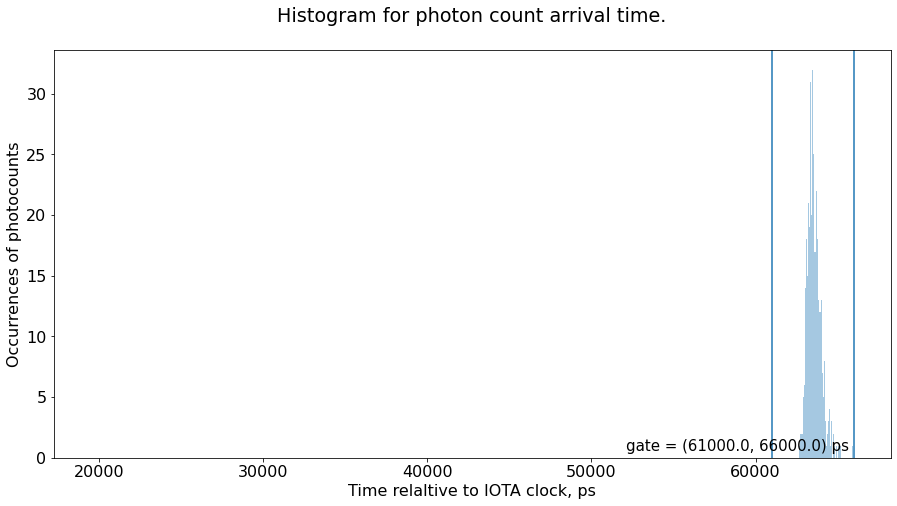

In [5]:
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [6]:
n_revolutions*133e-9

59.866547461

In [7]:
t_delays_in_gate = t_delays[t_delays.between(gate[0],gate[1])]

In [8]:
len(t_delays_in_gate)/n_revolutions/133e-9

24722.22071874391

In [9]:
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec

In [10]:
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz

In [11]:
four_gates = get_bucket_gates(gate)
four_gates

[(61000.0, 66000.0),
 (94250.0, 99250.0),
 (127500.00000000001, 132500.0),
 (27750.0, 32750.0)]

In [12]:
get_rate_in_gate_Hz(df, n_revolutions, gate)

24722.22071874391

In [13]:
bucket_dfs = [df[(df.delay > gate[0]) & (df.delay < gate[1])] for gate in four_gates]

In [14]:
dt=0.005

In [15]:
df0 = bucket_dfs[0]

In [16]:
revolutions_per_dt = dt/iota_period_sec
revolutions_per_dt

37593.984962406015

In [17]:
df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
df0['time_sec'] = df0['index_of_dt_bin']*dt

<ipython-input-17-27c4b84eb6f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['index_of_dt_bin'] = (df0.revolution/revolutions_per_dt).astype(int)
<ipython-input-17-27c4b84eb6f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['time_sec'] = df0['index_of_dt_bin']*dt


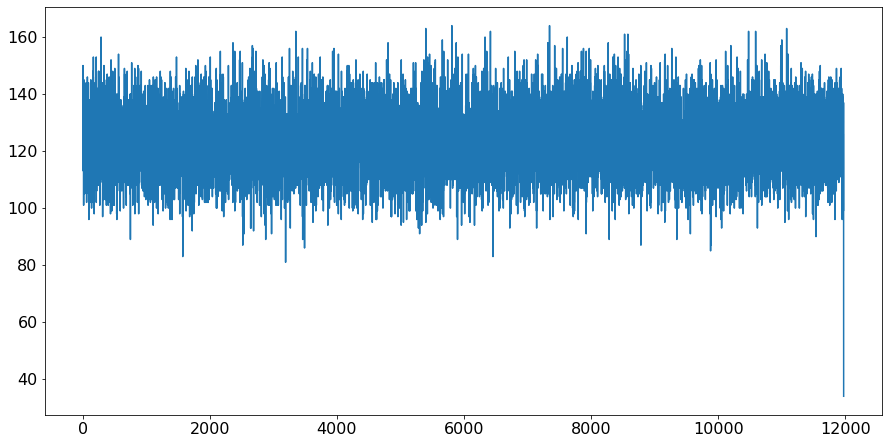

In [18]:
plt.plot(df0.groupby('index_of_dt_bin').delay.count())

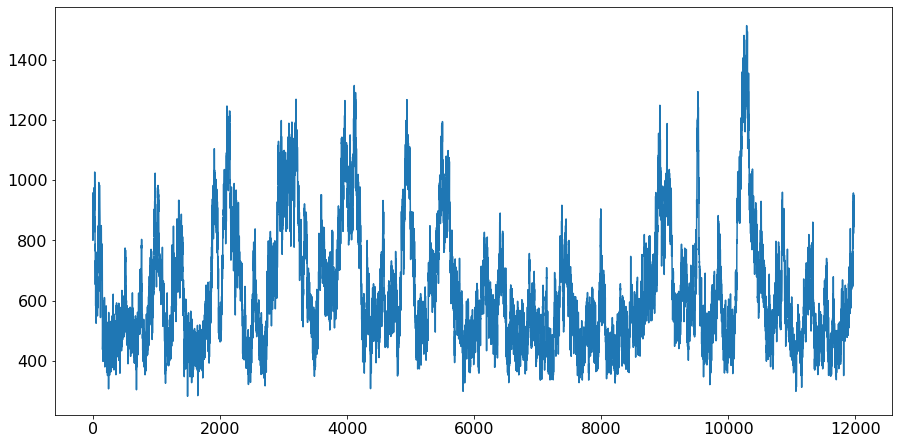

In [19]:
plt.plot(df0.groupby('index_of_dt_bin').delay.std())

In [20]:
xs = df0.groupby('index_of_dt_bin').revolution.apply(np.asarray)
ys = df0.groupby('index_of_dt_bin').delay.apply(np.asarray)

In [21]:
t0=2372

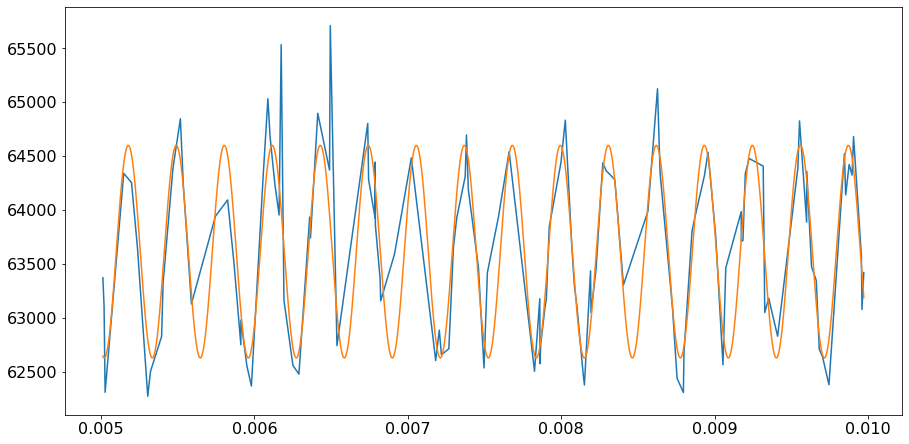

(985.823480014053, 2372, 4.012067972263142)

In [22]:
i = 1
x = xs[i]
x_sec = x*iota_period_sec
y = ys[i]
sns.lineplot(x=x_sec, y=y)
from scipy.optimize import curve_fit
def f(t, a0, A, B, T):
    return a0+A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)
p0 = (np.mean(y), np.std(y), np.std(y), t0)
popt, pcov = curve_fit(f, x, y, p0=p0)
a0, a, b, t = popt
perr = np.sqrt(np.diag(pcov))
x_fit = np.linspace(x[0],x[-1],10000)
x_fit_sec = x_fit*iota_period_sec
y_fit = f(x_fit, a0, a, b, t)
sns.lineplot(x_fit_sec, y_fit)
plt.show()
np.sqrt(a**2+b**2), t0, perr[3]

In [23]:
from config_ursse import save_to_config

In [24]:
Qs = 1/t0
save_to_config("Qs", Qs)

In [42]:
alpha = 0.07086 #0.07679
gamma = get_from_config("gamma")
me = get_from_config("me_MeV")
E = me*gamma*1e6
eta_s = alpha-1/gamma**2
beta = np.sqrt(1-1/gamma**2)
f0 = 1/get_from_config("IOTA_revolution_period")
h = 4
V=360  # V

In [43]:
Qs**2*2*np.pi*beta**2*E/h/V/eta_s

1.0948020112272556

In [44]:
1/200**2

2.5e-05

In [45]:
h*V*alpha/2/np.pi/Qs**2/1e6

91.37200211007418

In [39]:
alpha

0.07679

In [40]:
alpha-1/gamma**2

0.0767638879